In [3]:
#!pip download iisignature
!pip install "/kaggle/working/iisignature-0.24.tar.gz"

Processing ./iisignature-0.24.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=1401821 sha256=c285140803177a7ceb1ebf958ea7a9ebd9f5a490327b195edeb4615fc6b7d4d3
  Stored in directory: /root/.cache/pip/wheels/74/af/00/ce1acdb847324bebf10d5a73d4f3b03dfc1bd1f560aa9cce16
Successfully built iisignature


In [4]:
import sys
sys.path.append('/kaggle/usr/lib')

import numpy as np
import pandas as pd
import os
import time
import h5py

import iisignature as isig
from basic_preprocessing_utility_script import process_as_h5, signature, get_eeg_sp_data

import matplotlib.pyplot as plt



iisignature is already installed.


In [6]:
hdf5_file = '/kaggle/input/hms-data-first-third/hdf5/processed_dataset_0_17799.h5'


with h5py.File(hdf5_file, 'r') as file:
    # List all groups
    
    print("Keys: %s" % file.keys())
    
    file_keys = list(file.keys())

    a_group_key = list(file.keys())[0]
    
    eeg_data = np.array(file[f"eeg"])
    sp_data = np.array(file[f"sp"])
    targets = np.array(file[f"targets"])
    num_votes = np.array(file[f"num_votes"])
    num_votes = num_votes.reshape((len(num_votes), -1))

Keys: <KeysViewHDF5 ['eeg', 'num_votes', 'sp', 'targets']>


In [13]:
print(eeg_data.shape)
sp_data.shape

(17800, 2000, 18)


(17800, 4, 300, 100)

In [14]:
# signature transform

eeg_streams = [eeg_data[:,:,:4],  eeg_data[:,:,4:8], eeg_data[:,:,8:12], eeg_data[:,:,12:16], eeg_data[:,:,16:]]
eeg_stream_sig = [signature(stream, level=4) for stream in eeg_streams]

In [17]:
for stream in eeg_stream_sig:
    print(stream.shape)

(17800, 340)
(17800, 340)
(17800, 340)
(17800, 340)
(17800, 30)


In [18]:
eeg_sig = np.concatenate(eeg_stream_sig, axis=-1)

print(eeg_sig.shape)

(17800, 1390)


In [19]:
eeg_sig_clip = np.clip(eeg_sig, a_min=-0.5, a_max=0.5)

In [21]:
import numpy as np

# Mock data
features = eeg_sig_clip
targets = targets

In [92]:
from sklearn.model_selection import train_test_split, cross_val_predict
from xgboost import XGBClassifier, XGBRegressor


In [42]:
targets_majority = np.argmax(targets, axis=1)

(array([3681.,    0., 2402.,    0., 2973.,    0., 2359.,    0., 3393.,
        2992.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

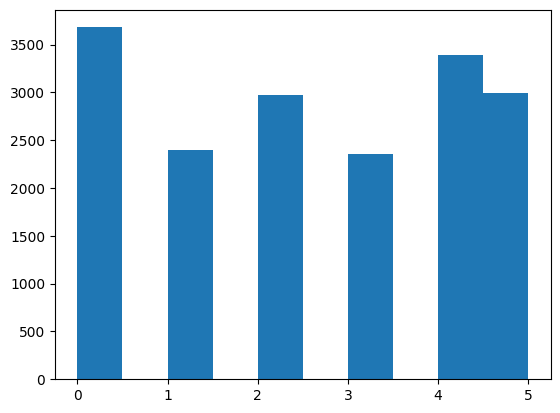

In [45]:
plt.hist(targets_majority)

In [75]:
np.random.seed(69)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.33, shuffle=True)

y_train_majority = np.argmax(y_train, axis=1)
y_test_majority = np.argmax(y_test, axis=1)

array([2, 5, 3, ..., 0, 3, 4])

In [67]:
# basic XGB classifier trained on majority vote instead of proba dist.

xgb = XGBClassifier(n_estimators=100)

training_start = time.perf_counter()
xgb.fit(X_train, y_train_majority)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test_majority).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 61.63
Time consumed for training: 77.073
Time consumed for prediction: 0.15619 seconds


In [ ]:
# evaluate accuracy of probability distribution predictions 

pred_proba = xgb.predict_proba(X_test)

In [93]:
# basic XGB classifier trained on majority vote instead of proba dist.

xgb = XGBRegressor(n_estimators=100)

training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
xgb_train_time = training_end-training_start

XGBoost's prediction accuracy is: 61.63
Time consumed for training: 77.752
Time consumed for prediction: 0.15619 seconds


In [95]:
preds_majority = np.argmax(preds, axis=1)
acc_xgb = (preds_majority == y_test_majority).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))


XGBoost's prediction accuracy is: 57.32


1.019734224052694

In [85]:
y_test.shape

(5874, 6)